In [1]:
# import libraries

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

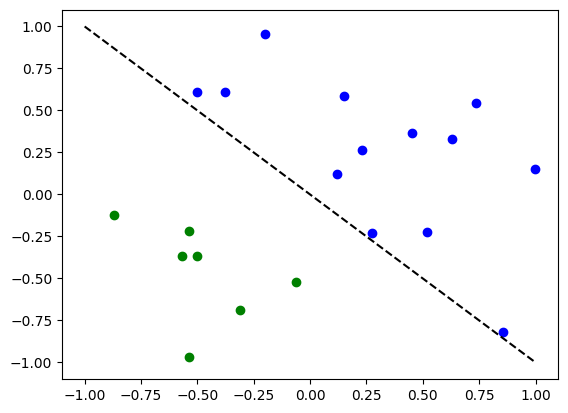

In [2]:
# set random seed and dataset

num_inputs = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()



In [3]:
# define callback to track objective function value

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

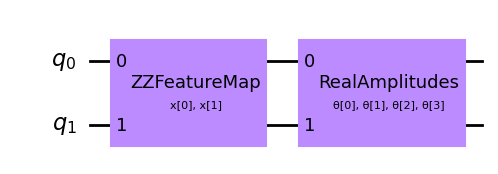

In [4]:
from qiskit.primitives import StatevectorSampler as Sampler
# define parity to be used as output function
'''
after measuring gien QNN circuit using samper primitives, we will get the output in the form of collection of bitstring.

thus, to get the +1 and -1 output, we will use the parity function which gives theses valuses based on the number of 1's in the bitstring.

input x -> convert to binary num -> count number of 1's -> return 1 if odd, 0 if even
'''
def parity(x):
    return "{:b}".format(x).count("1") % 2 

output_shape = 2  # parity has two outputs: 0 and 1

# create QNN instance and QNN classifier
qc = QNNCircuit( ansatz=RealAmplitudes(num_qubits=num_inputs, reps=1))
qc.draw("mpl", style="clifford")

In [6]:
sampler = Sampler()
sampler_qnn = SamplerQNN(
    circuit=qc,
    sampler=sampler,
    interpret=parity,
    output_shape=output_shape
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


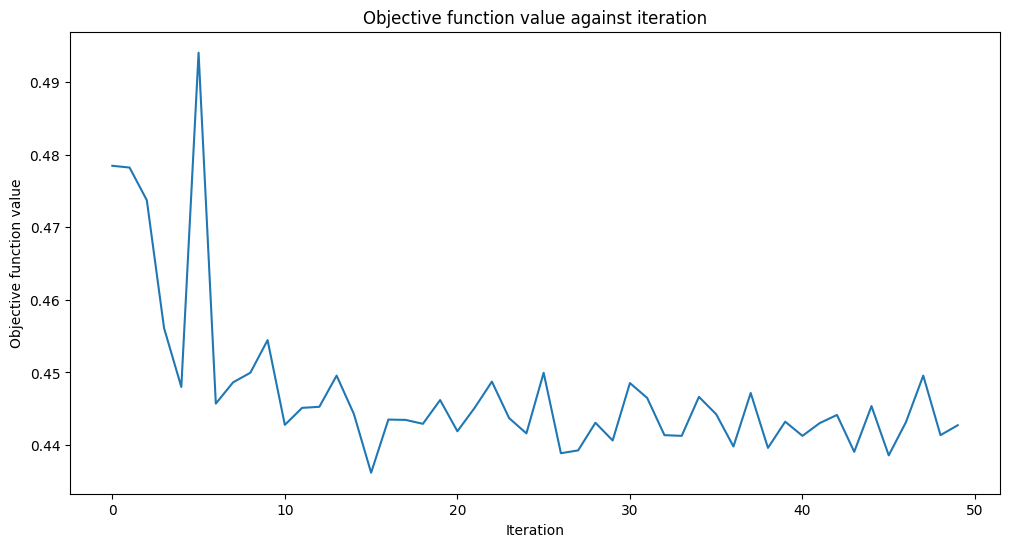

0.55

In [7]:
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn,
    optimizer=COBYLA(maxiter=60),
    callback=callback_graph
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
sampler_classifier.score(X, y01)

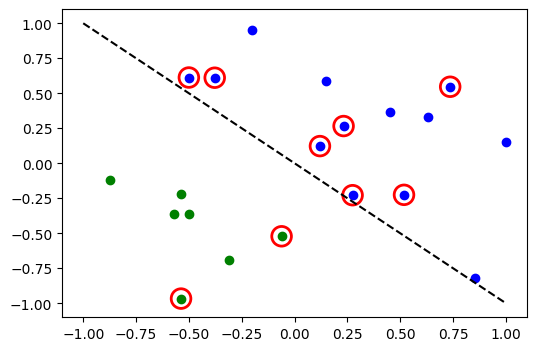

In [8]:
# evaluate data points
y_predict = sampler_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

